# Load and Preprocess Data

### Preprocess data to ensure all images are ready for model training and testing
#### Image dataset is from kaggle [here](https://www.kaggle.com/datasets/darren2020/ct-to-mri-cgan)

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch, torchvision

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available, Using GPU")
else:
    device = torch.device("cpu")
    print("CUDA is not available, Using CPU")

CUDA is available, Using GPU


In [3]:
DATASET_ROOT_PATH = "Dataset/images"
TRAIN_ROOT_PATH = "Dataset/images/train"
TEST_ROOT_PATH = "Dataset/images/test"

CT_TRAIN_PATH = "Dataset/images/train/trainA"
MRI_TRAIN_PATH = "Dataset/images/train/trainB"

CT_TEST_PATH = "Dataset/images/test/testA"
MRI_TEST_PATH = "Dataset/images/test/testB"

224 224


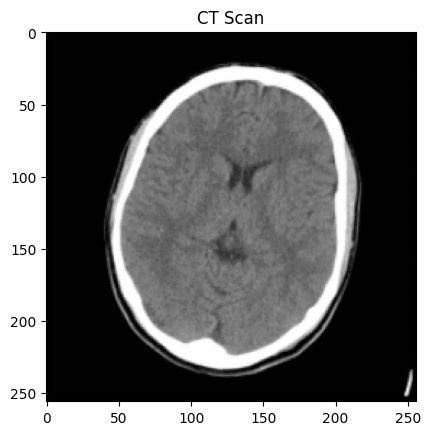

In [4]:
test_CT = cv.imread(CT_TRAIN_PATH+'/ct1.png')

### get image dimensions (and resize)
height, width, channels = test_CT.shape
print(height, width)
test_CT = cv.resize(test_CT, (256, 256))

### display image
plt.title("CT Scan")
plt.imshow(test_CT)

224 224


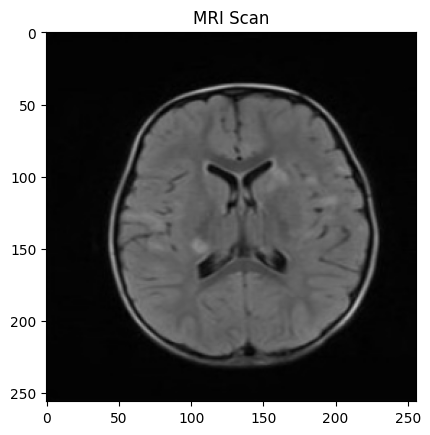

In [5]:
test_MRI = cv.imread(MRI_TRAIN_PATH+'/mri1.jpg')

### get image dimensions (and resize)
height, width, channels = test_MRI.shape
print(height, width)
test_MRI = cv.resize(test_MRI, (256, 256))

### display image
plt.title("MRI Scan")
plt.imshow(test_MRI)

Notice that the CT and MRI images are of different dimensions. Therefore the dimensions must be made constant across all images

### Resize all images to have the same dimensions

In [6]:
### resize MRI images to 512x512 and overwrite the image
def resize(image_path):
    image = cv.imread(image_path)
    height, width, channels = image.shape
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)    
    if height != 224 and width != 224:      
        image = cv.resize(image, (224, 224))
    # overwrite image
    cv.imwrite(image_path, image)

In [7]:
### resize all images
import os

for images in os.walk(CT_TRAIN_PATH):
    for image in images[2]:
        resize(CT_TRAIN_PATH+'/'+image)

for images in os.walk(CT_TEST_PATH):
    for image in images[2]:
        resize(CT_TEST_PATH+'/'+image)
 
for images in os.walk(MRI_TRAIN_PATH):
    for image in images[2]:
        resize(MRI_TRAIN_PATH+'/'+image)
 
for images in os.walk(MRI_TEST_PATH):
    for image in images[2]:
        resize(MRI_TEST_PATH+'/'+image)
 

In [8]:
### test if images are of same dimensions now

test_MRI = cv.imread(MRI_TRAIN_PATH+'/mri561.jpg')

### get image dimensions (and resize)
height, width, channels = test_MRI.shape
print(height, width, channels)

224 224 3


### Normalize the dataset

In [9]:
def normalize(image):
    image = (image/127.5) - 1
    return image

normalize_transform = transforms.Lambda(normalize)


In [10]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

In [11]:
train_dataset = datasets.ImageFolder(TRAIN_ROOT_PATH, transform=train_transform)
val_dataset = datasets.ImageFolder(TRAIN_ROOT_PATH, transform=test_transform)

### 80-20 split of training and validation data
train_set, _ = torch.utils.data.random_split(train_dataset, [2788, 698])
_, val_set = torch.utils.data.random_split(val_dataset, [2788, 698])

test_dataset = datasets.ImageFolder(TEST_ROOT_PATH, transform=test_transform)

### create dataloaders

In [12]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

### display some images

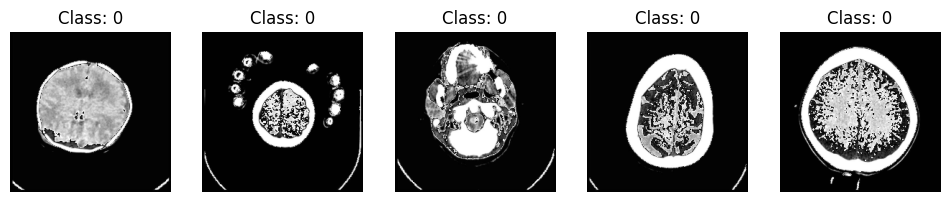

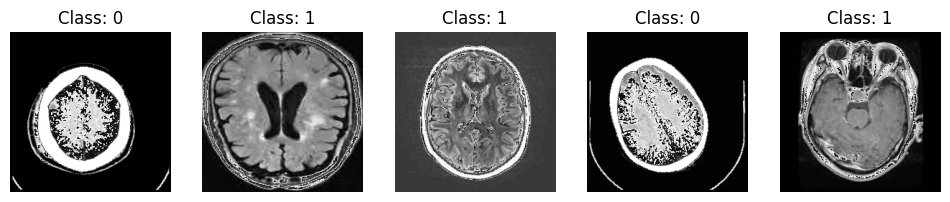

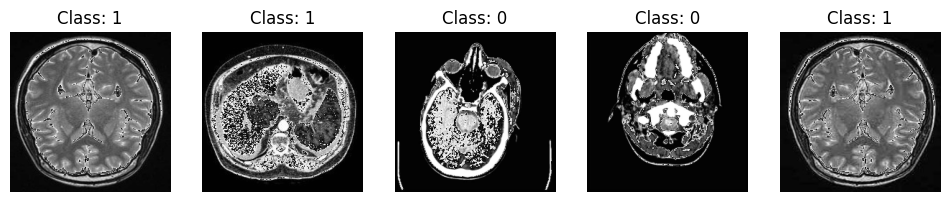

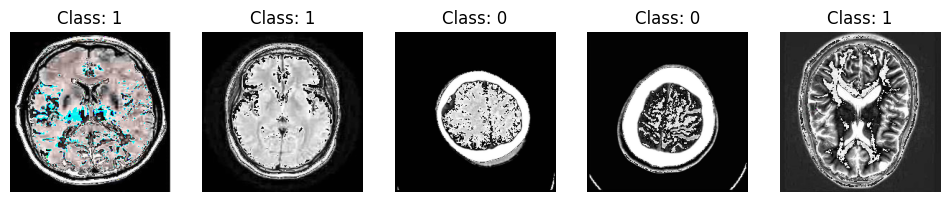

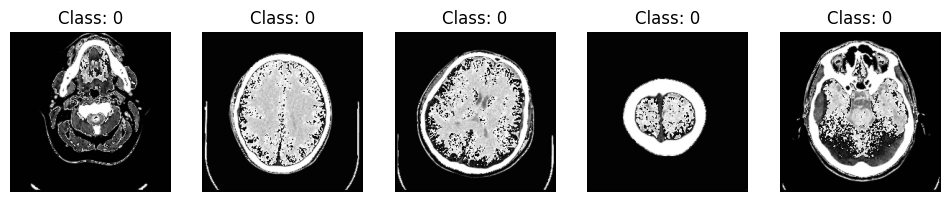

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display images
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for idx, (image, label) in enumerate(zip(images, labels)):
        image_np = (image * 255).byte().numpy()
        axes[idx].imshow(np.transpose(image_np, (1, 2, 0)))
        axes[idx].set_title(f"Class: {label}")
        axes[idx].axis('off')
    plt.show()

# Iterate over the data loader and display some images
count = 0
for batch_images, batch_labels in train_loader:
    show_images(batch_images[:5], batch_labels[:5])  # Display first 5 images
    count = count + 1
    if count == 5:
        break

# Model

### There are two parts to a GAN: A generator (G) and Discriminator (D). A cyclegan has two sets of GANs that translate from one domain to another and vice versa. 

In [68]:
import torch
import torch.nn as nn

In [69]:
class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        add_activation: bool = True,
        **kwargs
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )

    def forward(self, x):
        return self.conv(x)

In [70]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x) # add x to avoid vanishing gradient problem

In [71]:
class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 6
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer, 
        followed by 6 residual blocks for 128 × 128 training images 
        and then 3 upsampling/decoding layer. 
        
        The network with 6 residual blocks can be written as: 
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features, 
                    num_features * 2,
                    is_downsampling=True, 
                    kernel_size=3, 
                    stride=2, 
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))

In [72]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers += [
                nn.Conv2d(
                    in_channels,
                    feature,
                    kernel_size=4,
                    stride=1 if feature == features[-1] else 2,
                    padding=1,
                    padding_mode="reflect",
                ),
                nn.InstanceNorm2d(feature),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            in_channels = feature
        
        layers += [
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)
        x = self.model(x)
        return x


### Training

In [76]:
# Training discriminators for MRI and CT
from torchvision.utils import save_image
from tqdm import tqdm

LAMBDA_CYCLE = 10

def train_fn(
    disc_MRI, disc_CT, gen_CT, gen_MRI, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler
):
    MRI_reals = 0
    MRI_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (CT, MRI) in enumerate(loop):
        CT = CT.to(device)
        MRI = MRI.to(device)

        # Train discriminators MRI and CT
        with torch.cuda.amp.autocast():
            fake_MRI = gen_MRI(CT)
            D_MRI_real = disc_MRI(MRI)
            D_MRI_fake = disc_MRI(fake_MRI.detach())
            MRI_reals += D_MRI_real.mean().item()
            MRI_fakes += D_MRI_fake.mean().item()
            D_MRI_real_loss = mse(D_MRI_real, torch.ones_like(D_MRI_real))
            D_MRI_fake_loss = mse(D_MRI_fake, torch.zeros_like(D_MRI_fake))
            D_MRI_loss = D_MRI_real_loss + D_MRI_fake_loss

            fake_CT = gen_CT(MRI)
            D_CT_real = disc_CT(CT)
            D_CT_fake = disc_CT(fake_CT.detach())
            D_CT_real_loss = mse(D_CT_real, torch.ones_like(D_CT_real))
            D_CT_fake_loss = mse(D_CT_fake, torch.zeros_like(D_CT_fake))
            D_CT_loss = D_CT_real_loss + D_CT_fake_loss

            D_loss = (D_MRI_loss + D_CT_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generators MRI and CT
        with torch.cuda.amp.autocast():
            # adversarial losses
            D_MRI_fake = disc_MRI(fake_MRI)
            D_CT_fake = disc_CT(fake_CT)
            loss_G_MRI = mse(D_MRI_fake, torch.ones_like(D_MRI_fake))
            loss_G_CT = mse(D_CT_fake, torch.ones_like(D_CT_fake))

            # cycle losses
            cycle_CT = gen_CT(fake_MRI)
            cycle_MRI = gen_MRI(fake_CT)
            cycle_CT_loss = l1(CT, cycle_CT)
            cycle_MRI_loss = l1(MRI, cycle_MRI)

            # total loss
            G_loss = (
                loss_G_CT
                + loss_G_MRI
                + cycle_CT_loss * LAMBDA_CYCLE
                + cycle_MRI_loss * LAMBDA_CYCLE
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_MRI * 0.5 + 0.5, f"outputs/MRI_{idx}.png")
            save_image(fake_CT * 0.5 + 0.5, f"outputs/CT_{idx}.png")

        loop.set_postfix(MRI_real=MRI_reals / (idx + 1), MRI_fake=MRI_fakes / (idx + 1))




### Initialize Models

In [77]:
gen_mri_to_ct = Generator(img_channels=3, num_residuals=9).to(device)
gen_ct_to_mri = Generator(img_channels=3, num_residuals=9).to(device)

disc_MRI = Discriminator(in_channels=3).to(device)
disc_CT = Discriminator(in_channels=3).to(device)

### Initialize Optimizers

In [78]:
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

LEARNING_RATE = 0.0002
beta1 = 0.5  # Beta1 hyperparam for Adam optimizers
beta2 = 0.999  # Beta2 hyperparam for Adam optimizers

opt_disc = optim.Adam(
    list(disc_MRI.parameters()) + list(disc_CT.parameters()),
    lr=LEARNING_RATE,
    betas=(beta1, beta2),
)

opt_gen = optim.Adam(
    list(gen_mri_to_ct.parameters()) + list(gen_ct_to_mri.parameters()),
    lr=LEARNING_RATE,
    betas=(beta1, beta2)
)

L1 = nn.L1Loss()
mse = nn.MSELoss()